# HoltWinters for Time Series Forecasting

Holt-Winters is a time-series analysis technique, used in both forecasting future entries in a time series as well as in providing exponential smoothing, where weights are assigned against historical data with exponentially decreasing impact. It does this by analyzing three components of the data: level, trend, and seasonality. 

In order to convert your dataset to cudf format please read the cudf documentation on https://rapidsai.github.io/projects/cudf/en/latest/. For additional information on the ExponentialSmoothing model please refer to the documentation on https://rapidsai.github.io/projects/cuml/en/latest/index.html

This notebook will demonstrate how to forecast future datapoints using cuML's ExponentialSmoothing model by using weather data collected by NOAA at Raleigh-Durham International Airport between 2009 and today. It will predict weather patterns for the next 12 months, including temperature and precipitation. This notebook will also look at the accuracy of the algorithm as compared to statsmodels by using a train/test split on the average windspeed of the dataset, and finally run through some performance benchmarks on a mixture of different time series.

In [1]:
# import needed packages

from cuml import ExponentialSmoothing as cuES
import cudf
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing as smES
from sklearn.metrics import r2_score
from time import time

In [2]:
# ignore warning messages

import warnings
warnings.filterwarnings('ignore')

### Import NOAA RDU Weather Dataset

In [3]:
file_path = "../cuml/data/weather/noaa_rdu.csv"
pdf = pd.read_csv(file_path, sep=';')
pdf.head()

,date,temperaturemin,temperaturemax,precipitation,snowfall,snowdepth,avgwindspeed,fastest2minwinddir,fastest2minwindspeed,fastest5secwinddir,...,drizzle,snow,freezingrain,smokehaze,thunder,highwind,hail,blowingsnow,dust,freezingfog
0,2015-04-08,62.1,84.0,0.00,0.0,0.0,5.82,40.0,29.97,30.0,...,No,No,No,Yes,No,No,No,No,No,No
1,2015-04-20,63.0,78.1,0.28,0.0,0.0,11.86,180.0,21.92,170.0,...,No,No,No,No,Yes,No,No,No,No,No
2,2015-04-26,45.0,54.0,0.02,0.0,0.0,5.82,50.0,12.97,40.0,...,No,No,No,No,No,No,No,No,No,No
3,2015-04-28,39.0,69.1,0.00,0.0,0.0,2.68,40.0,12.08,40.0,...,No,No,No,No,No,No,No,No,No,No
4,2015-05-03,46.9,79.0,0.00,0.0,0.0,2.68,200.0,12.08,210.0,...,No,No,No,No,No,No,No,No,No,No


### Parse data and groupby month to accumulate average

In [4]:
def date_helper(month):
    if len(str(month)) == 1:
        return '0'+str(month)
    else:
        return str(month)

pdf['date'] = pd.to_datetime(pdf['date']).apply(lambda x : str(x.year) + '-' + date_helper(x.month))

pdf = pdf.groupby('date').mean()
pdf['month'] = pdf.index.map(lambda x : x[-2:])
pdf.tail()

,temperaturemin,temperaturemax,precipitation,snowfall,snowdepth,avgwindspeed,fastest2minwinddir,fastest2minwindspeed,fastest5secwinddir,fastest5secwindspeed,month
date,,,,,,,,,,,
2019-04,51.133333,72.416667,0.212000,0.0,0.0,7.314667,185.333333,18.238000,180.000000,24.546667,04
2019-05,62.680645,84.277419,0.103548,0.0,0.0,6.414839,227.419355,17.419032,197.096774,23.906129,05
2019-06,65.560000,86.333333,0.120000,0.0,0.0,6.443000,172.333333,16.427000,169.333333,22.400333,06
2019-07,70.341935,92.690323,0.117097,0.0,0.0,5.563871,152.258065,17.109355,174.516129,22.506129,07
2019-08,68.077778,89.233333,0.208889,0.0,0.0,4.026250,202.500000,20.747500,203.750000,29.276250,08


## Examine Monthly Max/Min Temperature

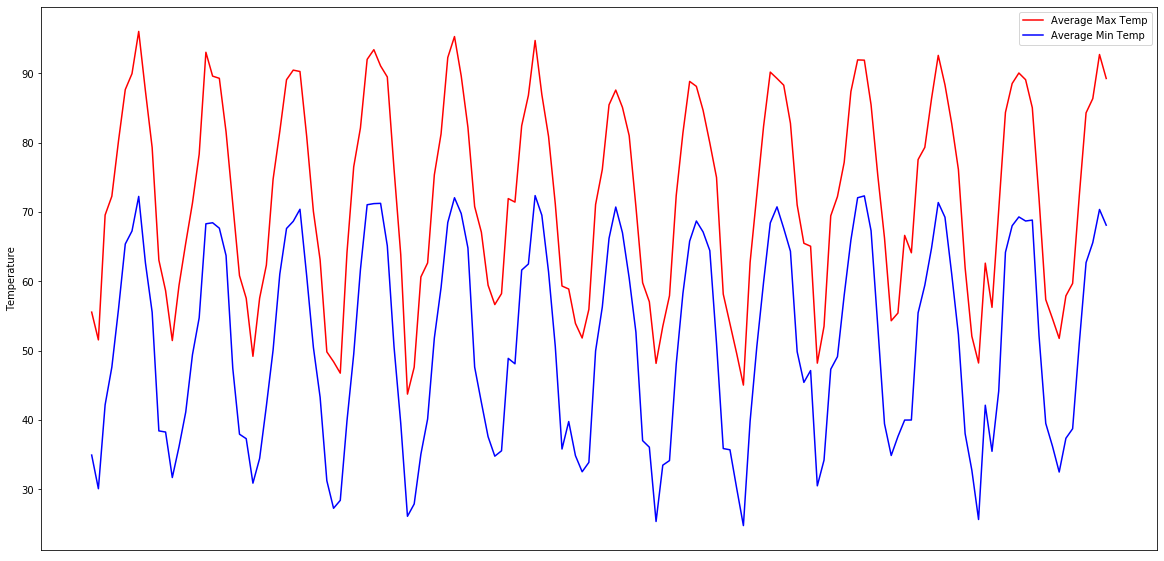

In [5]:
plt.figure(figsize=(20,10))
l1, = plt.plot(pdf['temperaturemax'], color = 'red')
l2, = plt.plot(pdf['temperaturemin'], color = 'blue')
plt.ylabel('Temperature')
plot1 = plt.gca()
plt.legend((l1, l2), ('Average Max Temp', 'Average Min Temp'), loc = 'best')
plot1.axes.get_xaxis().set_ticks([])
plt.show()

## Max/Min Temperature Over Past 2 Years

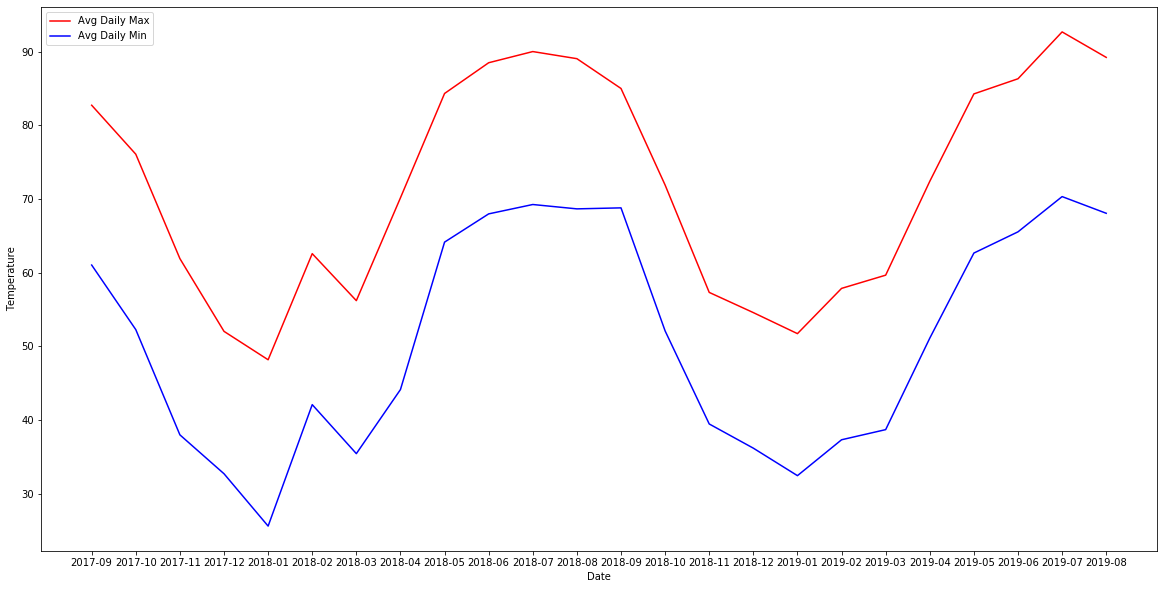

In [6]:
plt.figure(figsize=(20,10))
l1, = plt.plot(pdf.index[-24:], pdf['temperaturemax'].tail(24), color = 'red')
l2, = plt.plot(pdf['temperaturemin'].tail(24), color = 'blue')
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.legend((l1, l2), ('Avg Daily Max', 'Avg Daily Min'))
plt.show()

# Forecast Next 12 Months Using HoltWinters

Now we'll use cuML's HoltWinters algorithm to predict the average max/min temperature as well as the precipitation for the next year. First we create a cuDF.Dataframe of the data we want to predict on:

In [7]:
data = cudf.DataFrame.from_pandas(pdf[['temperaturemax','temperaturemin','precipitation']])
data.to_pandas().head()

,temperaturemax,temperaturemin,precipitation
date,,,
2007-01,55.535484,34.922581,0.100645
2007-02,51.532143,30.067857,0.062143
2007-03,69.541935,42.161290,0.113548
2007-04,72.243333,47.593333,0.129333
2007-05,80.287097,56.041935,0.046129


Begin by creating an `ExponentialSmoothing` object. Valid parameters include:

- `endog`: the endogenous dataset in question
- `seasonal` (default='additive'): whether the seasonality is "additive" or "multiplicative".
- `seasonal_periods` (default=2): seasonality of the data. As our data is monthly, we set this to 12.
- `start_periods` (default=2): number of seasons to be used for seasonal seed values.
- `ts_num` (default=1): number of different time series in `endog`.
- `eps` (default=2.24e-3): accuracy to which gradient descent should achieve.
- `handle` (default=None): cuml.Handle. A new one is created if None is passed.

The data in `endog` should be array-like, but can be any of type `cudf.dataframe`, `cupy.ndarray`, `numpy.ndarray`, or `cuda_array`. It is important to note that `cudf.dataframe` is column major, while the other types are row major. We then can fit the object to the data by using the `.fit()` method.

Finally, use the `.forecast()` method to return a cudf.Series or cudf.DataFrame of your forecasted points. Predict takes `h`, the number of points you would like to forecast, and `index`, the index of the time series from which you want forecasted points. If `index = None`, then the forecast is done for all points and a cudf.DataFrame of the results is returned.

- `h` (default=1): number of forecasted points to return.
- `index` (default=None): index of the time series from data from which you want the forecasted points.

In [8]:
months_to_predict = 12

cu_hw = cuES(data, seasonal_periods=12, ts_num=3)
cu_hw.fit()
cu_preds = cu_hw.forecast(months_to_predict)

tempmax_pred = cu_preds[0]
tempmin_pred = cu_preds[1]
precip_pred = cu_preds[2]

# Equivalent to:
# tempmax_pred = cu_hw.forecast(months_to_predict, 0)
# tempmin_pred = cu_hw.forecast(months_to_predict, 1)
# precip_pred = cu_hw.forecast(months_to_predict, 2)

# Forecasted Points Alongside Original Data

First, we compare how the forecasted points look when put alongside the original temperature data (just the last year, and then all data).

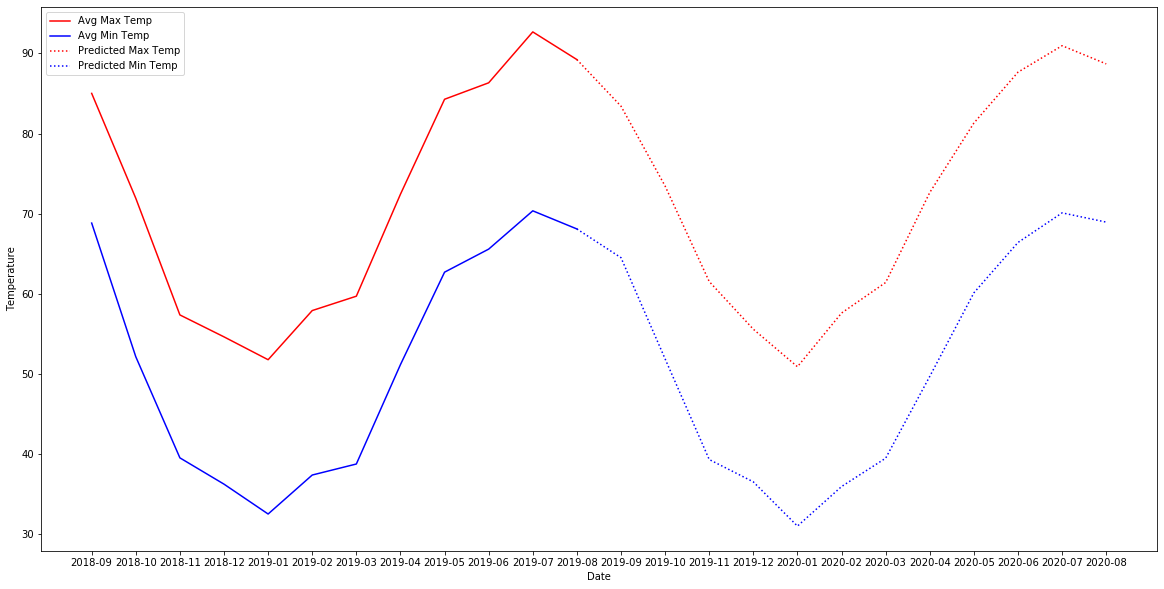

In [9]:
next_six_months = ['2019-08', '2019-09', '2019-10', '2019-11',
                   '2019-12', '2020-01', '2020-02', '2020-03',
                   '2020-04', '2020-05', '2020-06', '2020-07',
                   '2020-08']
tempmax_pred = np.insert(tempmax_pred, 0, pdf['temperaturemax'].iloc[-1])
tempmin_pred = np.insert(tempmin_pred, 0, pdf['temperaturemin'].iloc[-1])
precip_pred = np.insert(precip_pred, 0, pdf['precipitation'].iloc[-1])

plt.figure(figsize=(20,10))
l1, = plt.plot(pdf.index[-12:], pdf['temperaturemax'].tail(12), 'r-')
l2, = plt.plot(pdf.index[-12:], pdf['temperaturemin'].tail(12), 'b-')
p1, = plt.plot(next_six_months, tempmax_pred, 'r:')
p2, = plt.plot(next_six_months, tempmin_pred, 'b:')
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.legend((l1, l2, p1, p2), ('Avg Max Temp', 'Avg Min Temp', 'Predicted Max Temp', 'Predicted Min Temp'))
plt.show()

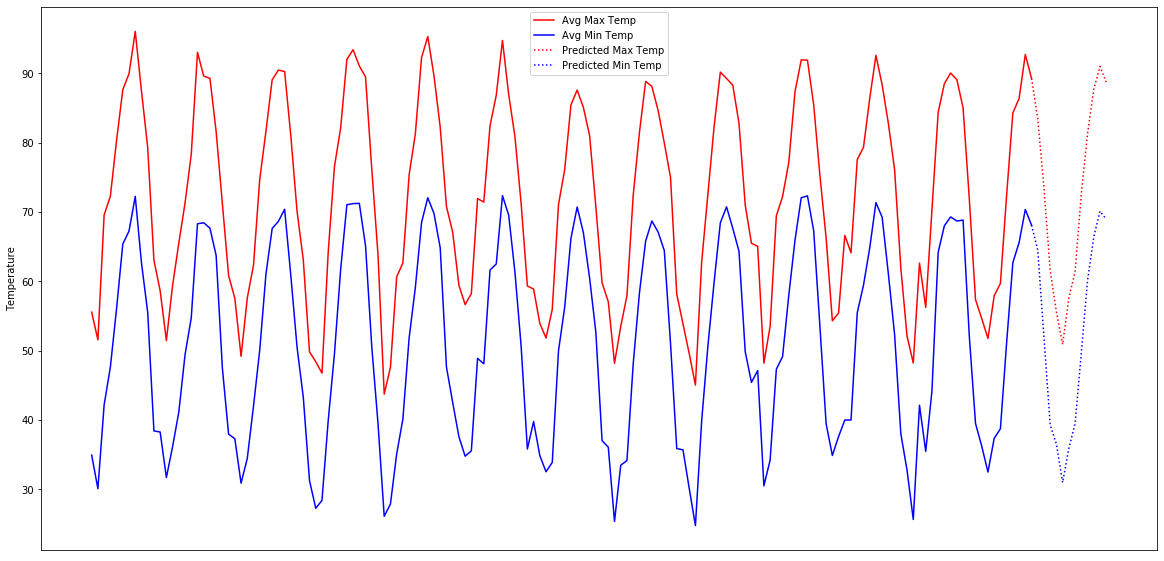

In [10]:
plt.figure(figsize=(20,10))

n = len(pdf.index)

l1, = plt.plot(np.arange(n), pdf['temperaturemax'], 'r-')
l2, = plt.plot(np.arange(n), pdf['temperaturemin'], 'b-')
p1, = plt.plot(np.arange(months_to_predict+1)+n-1, tempmax_pred, 'r:')
p2, = plt.plot(np.arange(months_to_predict+1)+n-1, tempmin_pred, 'b:')
plt.ylabel('Temperature')
plot1 = plt.gca()
plt.legend((l1, l2, p1, p2), ('Avg Max Temp', 'Avg Min Temp', 'Predicted Max Temp', 'Predicted Min Temp'))
plot1.axes.get_xaxis().set_ticks([])
plt.show()

# Examine Precipitation Forecast

Next we examine the forecast for a less "nice" dataset: the precipitation levels over the past years.

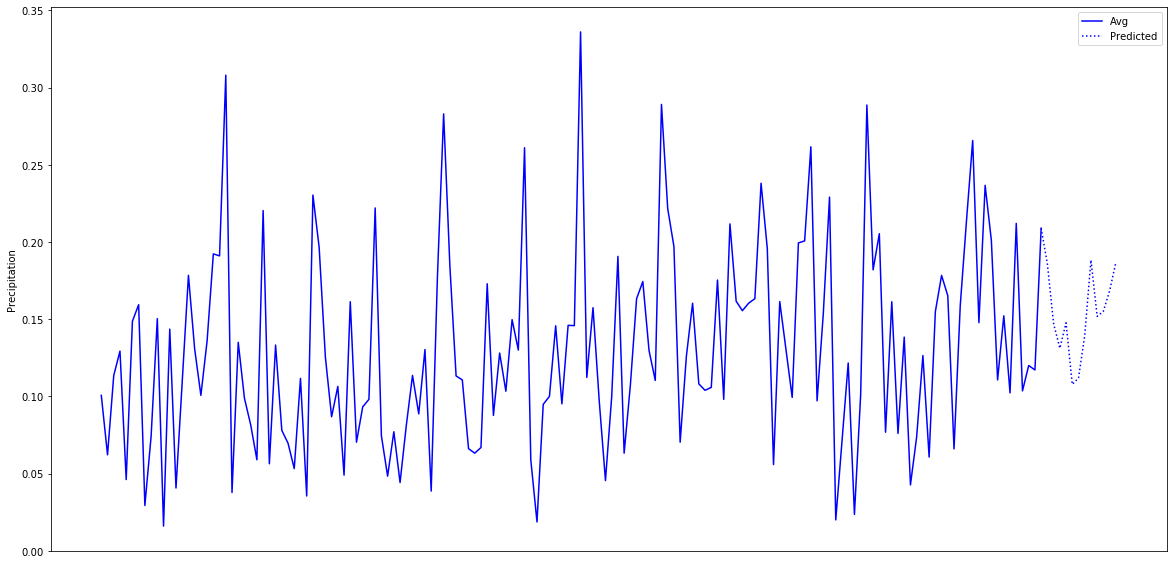

In [11]:
plt.figure(figsize=(20,10))
l1, = plt.plot(np.arange(n), pdf['precipitation'], 'b-')
p1, = plt.plot(np.arange(months_to_predict+1)+n-1, precip_pred, 'b:')
plt.ylabel('Precipitation')
plot1 = plt.gca()
plt.legend((l1, p1), ('Avg', 'Predicted'))
plot1.axes.get_xaxis().set_ticks([])
plt.show()

# Compare Accuracy to StatsModels on Windspeed Dataset

The last thing we'll do with our NOAA dataset is to compare the accuracy of cuML's ExponentialSmoothing with statsmodels' ExponentialSmoothing. To do this, we'll take the windspeed data, do a train/test split, and take the r2 scores of both statsmodels' forecasted points and cuML's forecasted points as compared to the test points.

In [12]:
# Get Windspeed data from dataframe
wind_data = pdf['avgwindspeed'].values

# Test/Train Split
spl = 0.2
wind_data = np.asarray(wind_data, dtype=np.float64)
h = int(wind_data.shape[0]*spl)
train = wind_data[:-h]
test = wind_data[-h:]


# cuML HoltWinters
cu_hw = cuES(train, seasonal='additive', seasonal_periods=12)
cu_hw.fit()
cu_pred = cu_hw.forecast(h)

# statsmodels ExponentialSmoothing
sm_hw = smES(train, seasonal='additive', seasonal_periods=12)
sm_hw = sm_hw.fit()
sm_pred = sm_hw.forecast(h)

cu_r2 = r2_score(test, cu_pred)
sm_r2 = r2_score(test, sm_pred)

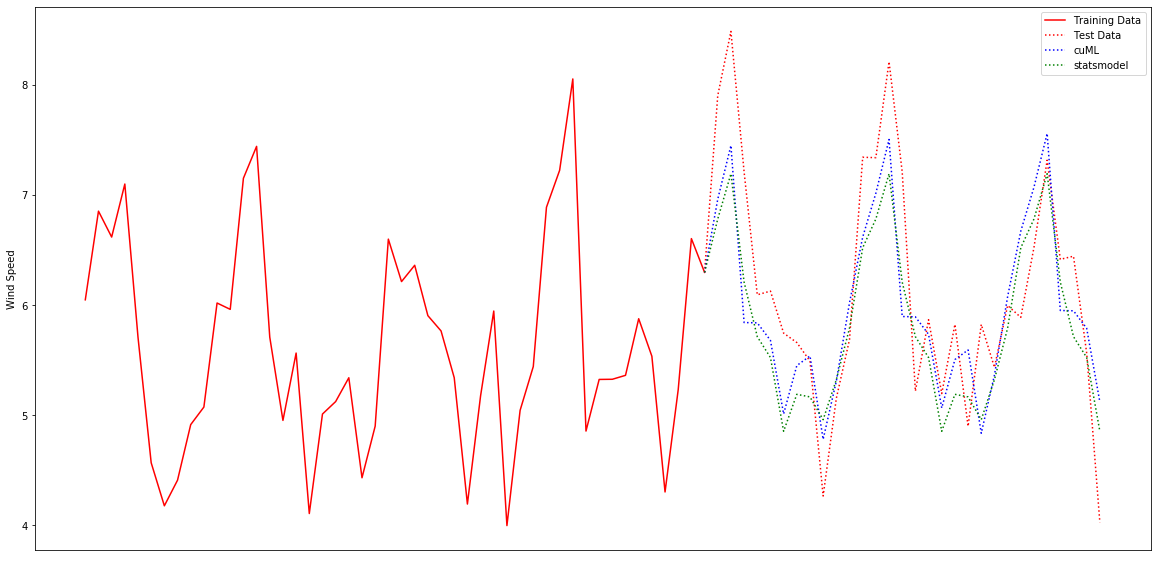

cuML accuracy score: 0.6292039115244635
statsmodels accuracy score: 0.6314632704589254


In [13]:
plt.figure(figsize=(20,10))

n = int(0.4*train.shape[0])

test = np.insert(test, 0, train[-1])
cu_pred = np.insert(cu_pred, 0, train[-1])
sm_pred = np.insert(sm_pred, 0, train[-1])

tr_d, = plt.plot(np.arange(n), train[-n:], 'r-')
te_d, = plt.plot(np.arange(h+1)+n-1, test, 'r:')
cu, = plt.plot(np.arange(h+1)+n-1, cu_pred, 'b:')
sm, = plt.plot(np.arange(h+1)+n-1, sm_pred, 'g:')
plt.ylabel('Wind Speed')
plot1 = plt.gca()
plt.legend((tr_d, te_d, cu, sm), ('Training Data', 'Test Data', 'cuML', 'statsmodel'))
plot1.axes.get_xaxis().set_ticks([])
plt.show()

print('cuML accuracy score: ' + str(cu_r2))
print('statsmodels accuracy score: ' + str(sm_r2))

# Comparing Speed to Statsmodels

Finally, we'll see how statsmodels and cuML compare on their speed of execution.

## Time Series Generator
To do this, we'll need a way of creating a large number of datasets. Here, we define functions to artificially create trends (which implicitly defines a level), seasons (via sine waves), and Gaussian noise.

In [14]:
def trend(x, m=1, b=0):
    return m*x + b

def sine_season(x, fs=100, f=2, amp=1):
    return amp * np.sin(2*np.pi*f * (x/fs))

def normal_noise(scale=1, size=1):
    return np.random.normal(scale=scale, size=size)

By combining them, we can create artificial time series on which to test our execution speed:

In [15]:
def get_timeseries_components(fs=100, f=4, m=1, b=0, amp=1, scale=1):
    x = np.arange(fs)
    t = trend(x, m, b)
    s = sine_season(x, fs, f, amp)
    n = normal_noise(scale, fs)
    return (t, s, n)

In [16]:
t, s, n = get_timeseries_components(100, 4, 1, 0, 20, 2.5)
a = t + s + n
split = 75
train_a = a[:split]
test_a = a[split:]

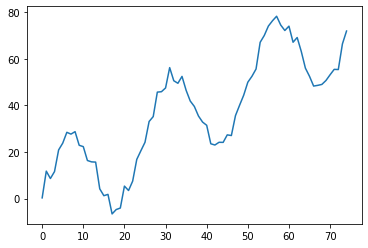

In [17]:
plt.plot(train_a)

## cuES and smES on Our Time Series Generator
We now can examine how long it takes to fit our cuML model (cuES) as well as our statsmodels model (smES) on the above time series:

In [18]:
%%time

cu = cuES(train_a, seasonal_periods=25, start_periods=2, ts_num=1, eps=2.24e-7, seasonal='add')
cu = cu.fit()

CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 18.3 ms


In [19]:
%%time

sm = smES(train_a, seasonal_periods=25, seasonal='add')
sm = sm.fit()

CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 15 ms


We can also see how well these models forecast future points in our time series, both visually as well as by again looking at the r2 score as compared to the test split.

Text(0.5, 1.0, 'cuml vs statsmodels predictions on sine waves')

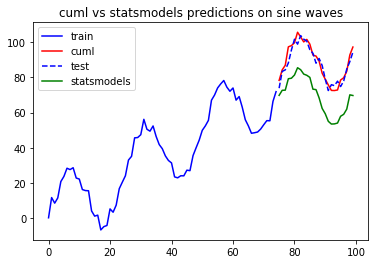

In [20]:
cu_f = cu.forecast(25)
sm_f = sm.forecast(25)
plt.plot(np.arange(0, split), train_a, color='b')
plt.plot(np.arange(split, 100), cu_f.to_pandas(), color='r')
plt.plot(np.arange(split, 100), test_a, color='b', linestyle='dashed')
plt.plot(np.arange(split, 100), sm_f, color='g')
plt.legend(['train', 'cuml', 'test', 'statsmodels'])
plt.title("cuml vs statsmodels predictions on sine waves")

In [21]:
r2_score(test_a, cu_f), r2_score(test_a, sm_f)

(0.8657013962314608, -2.7001255196189415)

## cuES Over Multiple Generated TS

We now demonstrate that the same process could be used to generate multiple unique time series with different frequencies, amplitude, and noise. By putting the time series into a single DataFrame, we can use cuES to fit over all series at the same time.

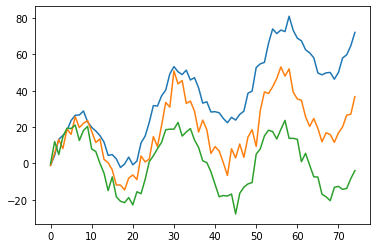

In [22]:
ta, sa, na = get_timeseries_components(m=1, amp=20, scale=2.5)
tb, sb, nb = get_timeseries_components(m=0.5, amp=20, scale=5)
tc, sc, nc = get_timeseries_components(m=0, amp=20, scale=3.3)
a = ta + sa + na
b = tb + sb + nb
c = tc + sc + nc
split = 75
train_a, train_b, train_c = a[:split], b[:split], c[:split]
test_a, test_b, test_c = a[split:], b[split:], c[split:]
train_df = cudf.DataFrame({"a":train_a, "b":train_b, "c":train_c})
test_df = cudf.DataFrame({"a":test_a, "b":test_b, "c":test_c})
plt.plot(train_df.to_pandas())

In [23]:
%%time

cu = cuES(train_df, seasonal_periods=25, start_periods=3, ts_num=3, eps=2.24e-7, seasonal='additive')
cu = cu.fit()

CPU times: user 8 ms, sys: 16 ms, total: 24 ms
Wall time: 22 ms


## Comparison Numbers

Now for the final comparisons: we'll use the above generator to create a large number of series, stick them into a DataFrame, and compare the time it takes to run cuES over the DataFrame, or equivalently, smES over each column. We begin by creating the DataFrame:

In [24]:
# Initialize parameters:
np.random.seed(100)
single_series_len = 1250
num_of_series = 1000
tt_split = int(0.8*num_of_series)
train_pdf = pd.DataFrame()
test_pdf = pd.DataFrame()

#Create Dataframe of series:
for i in range(num_of_series):
    t, s, n = get_timeseries_components(fs=single_series_len,
                                        f = 4,
                                        m = np.random.uniform(-2, 2),
                                        b = np.random.uniform(-3, 3),
                                        amp = np.random.uniform(-1, 1),
                                        scale = np.random.uniform(1, 3))
    time_series = t + s + n
    train_pdf[i] = time_series[:tt_split]
    test_pdf[i] = time_series[tt_split:]
    
train_pdf[train_pdf.columns[:5]].head(5)

,0,1,2,3,4
0,1.309530,2.642145,-0.292117,-0.792474,1.921168
1,0.223819,-3.975194,-3.470181,-1.823214,3.912476
2,-0.393739,-6.637004,-0.311844,-3.955948,5.362361
3,-3.695962,-5.684664,-7.171162,-2.932269,2.696879
4,-1.157092,-4.079032,-3.202332,-4.614897,6.478258


Next, we time how long it takes for us to fit both cuES and smES over all the columns of our DataFrame. Note that on several occasions, statsmodels fails to converge, which could possibly accelerate its computation time (exiting earlier).

In [25]:
#Raw time comparisons

train_gdf = cudf.from_pandas(train_pdf)
cu_st = time()
cu = cuES(train_gdf, seasonal_periods=int(single_series_len/4), seasonal='add', ts_num=num_of_series)
cu.fit()
cu_et = time()

sm_st = time()
for column in train_pdf:
    sm = smES(train_pdf[column], seasonal_periods=int(single_series_len/4), seasonal='add')
    sm = sm.fit()
sm_et = time()

print("For " + str(num_of_series) + " columns of length " + str(single_series_len)
      + " it takes cuml " + str(cu_et - cu_st) + " seconds to fit.")
print()
print("For " + str(num_of_series) + " columns of length " + str(single_series_len)
      + " it takes statsmodels " + str(sm_et - sm_st) + " seconds to fit.")

For 1000 columns of length 1250 it takes cuml 4.129880905151367 seconds to fit.

For 1000 columns of length 1250 it takes statsmodels 86.940016746521 seconds to fit.


If we wanted to, we could also time predictions and compare their r2 score to the test data.

In [26]:
num_of_series = 100

#take only 100 samples
train_pdf = train_pdf[train_pdf.columns[:num_of_series]]
test_arr = test_pdf[test_pdf.columns[:num_of_series]].values.transpose()
num_of_preds = test_arr.shape[1]

#timing for cuES to forecast points from each time series
train_gdf = cudf.from_pandas(train_pdf)
cu_st = time()
cu = cuES(train_gdf, seasonal_periods=int(single_series_len/4), seasonal='add', ts_num=num_of_series)
cu.fit()
cu_preds = cu.forecast(num_of_preds)
cu_et = time()

#timing for smES to forecast points from each time series
sm_preds = np.zeros((num_of_series, num_of_preds))
sm_st = time()
for i in range(len(train_pdf.columns)):
    sm = smES(train_pdf[train_pdf.columns[i]], seasonal_periods=int(single_series_len/4), seasonal='add')
    sm = sm.fit()
    sm_preds[i] = sm.forecast(num_of_preds)
sm_et = time()

cu_preds = cu_preds.as_matrix().transpose()
cu_r2_scores = r2_score(test_arr, cu_preds)
sm_r2_scores = r2_score(test_arr, sm_preds)

print("Forecasting " + str(num_of_preds) + " points for " + str(num_of_series) + " different time series:")
print("cuES: " + str(cu_et - cu_st) + " s")
print("smES: " + str(sm_et - sm_st) + " s")
print()
print("Average cuES r2 score: " + str(np.mean(cu_r2_scores)))
print("Average smES r2 score: " + str(np.mean(sm_r2_scores)))

Forecasting 450 points for 100 different time series:
cuES: 1.2030627727508545 s
smES: 8.797118663787842 s

Average cuES r2 score: 0.9999663738516915
Average smES r2 score: 0.9416324855898052


# Additional Notes and Warnings:

**Known Limitations**:
    This version of ExponentialSmoothing currently provides only a limited
    number of features when compared to the
    statsmodels.holtwinters.ExponentialSmoothing model. Noticeably, it lacks:
- `.predict()` : no support for in-sample prediction.
                 (https://github.com/rapidsai/cuml/issues/875)
- `.hessian()` : no support for returning Hessian matrix.
                 (https://github.com/rapidsai/cuml/issues/880)
- `.information()` : no support for returning Fisher matrix.
                     (https://github.com/rapidsai/cuml/issues/880)
- `.loglike()` : no support for returning Log-likelihood.
                 (https://github.com/rapidsai/cuml/issues/880)
                         
Additionally, be warned that there may exist floating point instability
issues in this model. Small values in endog may lead to faulty results.
See https://github.com/rapidsai/cuml/issues/888 for more information.
    
**Known Differences**:
This version of ExponentialSmoothing differs from statsmodels in some
other minor ways:
- `.__init__()` : Cannot pass trend component or damped trend component
- `.__init__()` : this version can take additional parameters (eps, start_periods, ts_num, handle)
- `.score()` : returns SSE rather than gradient logL
               (https://github.com/rapidsai/cuml/issues/876)
- this version provides `get_level()`, `get_trend()`, `get_season()`